**Отображатель графиков обучения**



In [50]:
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
from tensorflow.keras import backend as K

class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        clear_output(wait=True)
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss:" + str(round(logs.get('loss'), 2)))
        ax1.plot(self.x, self.val_losses, label="v_loss:" + str(round(logs.get('val_loss'), 2)))
        ax1.legend()
        ax2.plot(self.x, self.acc, label="acc:" + str(round(logs.get('accuracy'), 2)))
        ax2.plot(self.x, self.val_acc, label="v_acc:" + str(round(logs.get('val_accuracy'), 2)))
        ax2.legend()
        plt.savefig("fig")
        plt.show()

plot = PlotLearning()

**Загрузка и исследование датасета**

Изменения:
 - Уменьшил размер обучающей выборки для ускорения экспериментов.
 - Добавил перемешивание данных для лучшей генерализации.





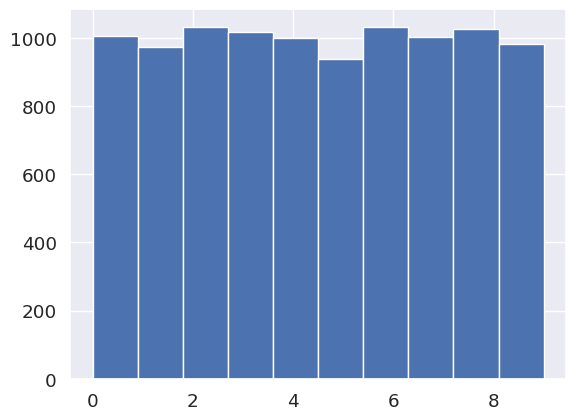

In [51]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
import os
import tensorflow.keras as keras
import numpy as np

num_classes = 10
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train[:10000]
y_train = y_train[:10000]
idx = np.arange(len(x_train))
np.random.shuffle(idx)
x_train = x_train[idx]
y_train = y_train[idx]
plt.hist(y_train, num_classes)
plt.show()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

**Создание и обучение модели**

Изменения:

 - Добавлен Dropout для борьбы с переобучением.

 - Использован BatchNormalization для ускорения и стабилизации обучения.

 - Увеличена глубина сети.

 - Добавлена l1_l2-регуляризация.

 - Learning rate уменьшен для более стабильного обучения.


In [52]:
from tensorflow.keras.layers import Dropout, BatchNormalization, InputLayer, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler

def swish(x):
    return x * K.sigmoid(x)

model = Sequential()
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(1024, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(768, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(Activation(swish))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Activation(swish))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

opt = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 768)            │       787,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,471,818 (17.06 MB)

 Trainable params: 4,466,698 (17.04 MB)

 Non-trainable params: 5,120 (20.00 KB)

**Обучение с аугментацией**

Изменения:

 - Увеличен batch_size до 512 для более стабильного градиента.

 - epochs увеличено до 50 для лучшей сходимости.

 - Добавлена аугментация (сдвиги, повороты, зум).


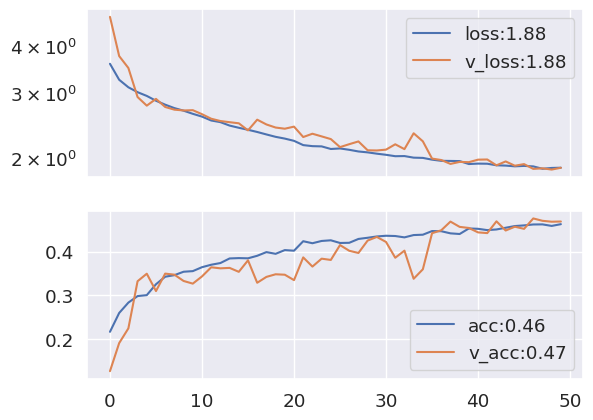

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.4643 - loss: 1.8864 - val_accuracy: 0.4687 - val_loss: 1.8836 - learning_rate: 2.5000e-04


In [53]:
batch_size = 512
epochs = 50

datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest'
)

model.fit(datagen.flow(x_train, y_train,
                        batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=[plot, early_stop, lr_scheduler])

**Визуализация**

Изменения не производилось

          GT class           Predicted class


<ipython-input-54-8c37518f5487>:16: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, (4., 4.))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


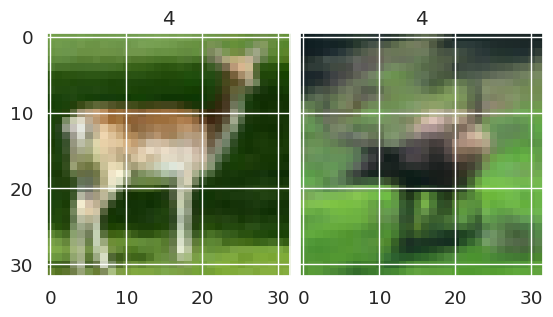

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


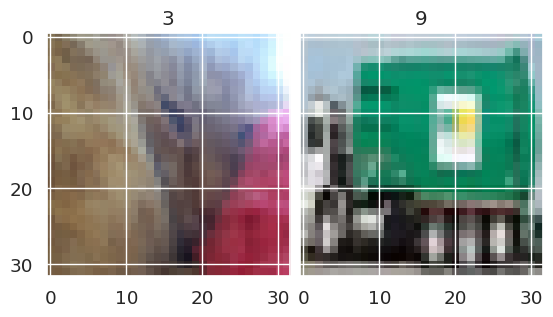

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


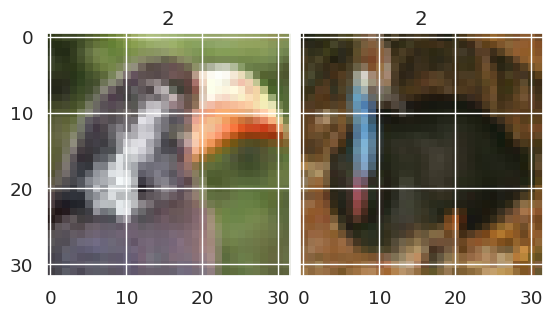

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


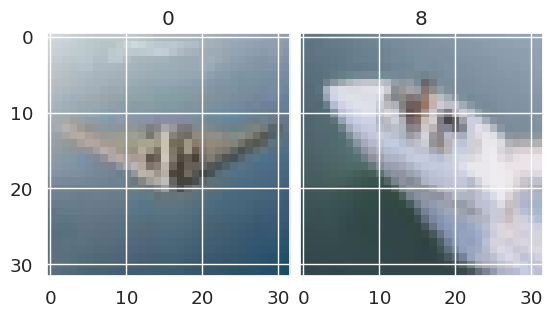

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


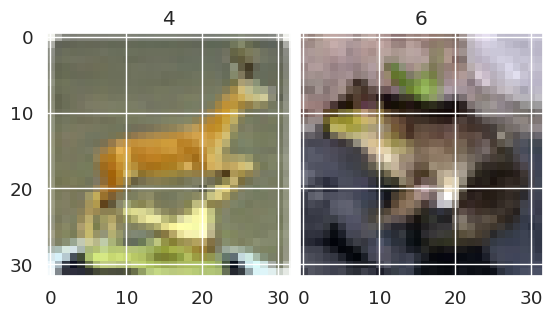

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


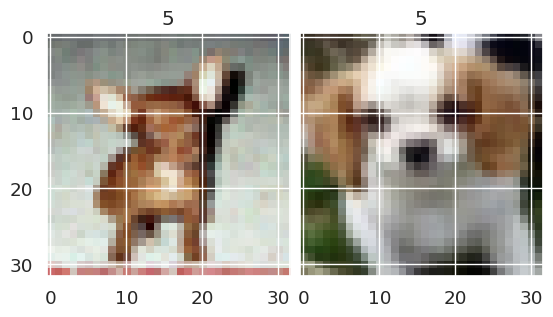

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


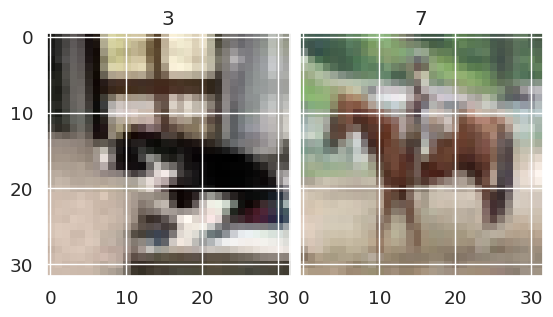

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


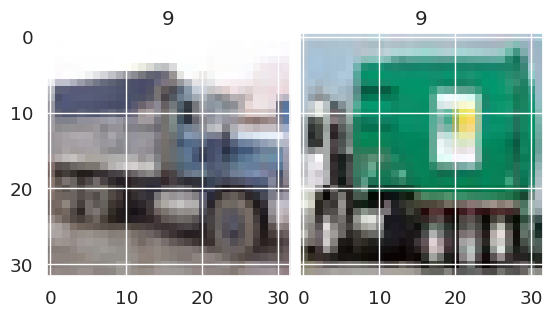

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


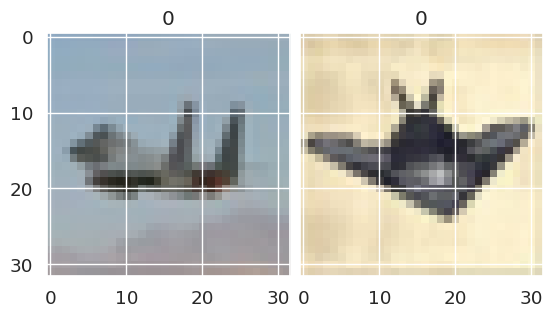

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


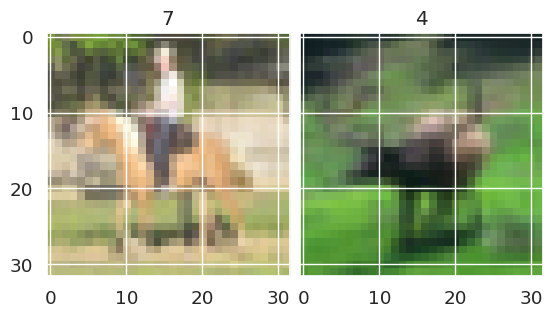

In [54]:
from matplotlib.colors import Colormap
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

def get_class_sample(cls_index):
    for i in range(len(y_train)):
        if np.argmax(y_train[i]) == cls_index:
            return x_train[i]
    return None

print("          GT class           Predicted class")

for i in range(10):
    plt.set_cmap(Colormap("Greys"))
    fig = plt.figure(1, (4., 4.))
    grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.1,
                 )
    images = []
    np_images = []
    k = random.randint(0,len(x_test)-1)
    images.append(np.expand_dims(x_test[k], axis=0))
    np_images = np.vstack(images)
    y = model.predict(np_images)
    c = np.argmax(y[0])
    cls_name_pred = c
    cls_name_gt = np.argmax(y_test[k])
    img = x_test[k]
    img_pred = get_class_sample(cls_name_pred)
    grid[0].imshow(np.reshape(img,(32,32,3)))
    grid[0].set_title("{}".format(cls_name_gt))
    grid[1].imshow(np.reshape(img_pred,(32,32,3)))
    grid[1].set_title("{}".format(cls_name_pred))
    plt.show()

**Матрица ошибок**

Изменения не производились


<Axes: >

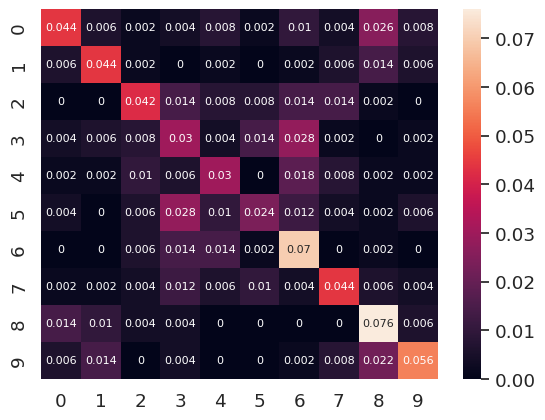

In [55]:
import pandas as pd
import seaborn as sn
from google.colab import output

def get_conf_matrix(x_test, y_test):
    p0 = []
    m = np.zeros((10,10))
    acc = 0
    i = 0
    for x in x_test:
        p = model.predict(np.expand_dims(x, axis=0))
        yp = np.argmax(p)
        ygt = np.argmax(y_test[i])
        if ygt == 0:
            p0.append(p[0][ygt])
        m[ygt,yp] += 1
        i = i+1
    m = m/len(y_test)
    return m, p0

m, p0 = get_conf_matrix(x_test[:500], y_test[:500])
output.clear()
df_cm = pd.DataFrame(m, range(10), range(10))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})

**Гистограмма вероятностей**

Изменения не производились

[np.float32(0.11135923), np.float32(0.30890578), np.float32(0.48106104), np.float32(0.1234188), np.float32(0.20610069), np.float32(0.013295595), np.float32(0.12474185), np.float32(0.49768522), np.float32(0.35952786), np.float32(0.05915648), np.float32(0.3547545), np.float32(0.44545406), np.float32(0.0591937), np.float32(0.15320729), np.float32(0.19418746), np.float32(0.1923851), np.float32(0.09093317), np.float32(0.13351662), np.float32(0.45065206), np.float32(0.013903631), np.float32(0.41205803), np.float32(0.16312025), np.float32(0.73714495), np.float32(0.2769503), np.float32(0.61966646), np.float32(0.14790146), np.float32(0.15886733), np.float32(0.04738444), np.float32(0.06044091), np.float32(0.12239098), np.float32(0.22980988), np.float32(0.0050891936), np.float32(0.09423411), np.float32(0.13756907), np.float32(0.7097475), np.float32(0.35541654), np.float32(0.43300498), np.float32(0.24487911), np.float32(0.4422851), np.float32(0.09307176), np.float32(0.17861179), np.float32(0.02234

(array([12., 16.,  7.,  3.,  5.,  7.,  2.,  2.,  2.,  1.]),
 array([0.00508919, 0.0882376 , 0.171386  , 0.25453442, 0.33768281,
        0.42083123, 0.50397962, 0.58712804, 0.6702764 , 0.75342488,
        0.8365733 ]),
 <BarContainer object of 10 artists>)

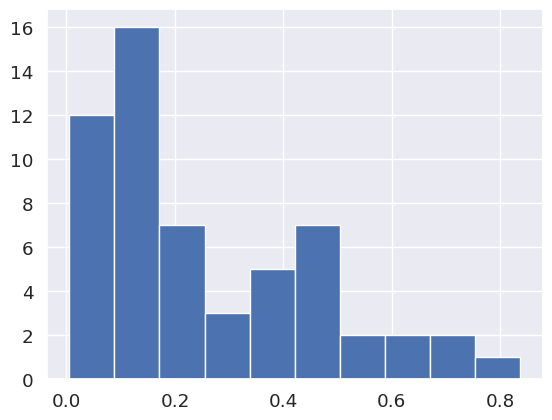

In [56]:
print(p0)
plt.hist(p0, 10)

**Классификация произвольного изображения**

Изменения не производились

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(856, 1500, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.5522569  0.02414119 0.16372207 0.04922591 0.06585174 0.01044988
  0.01416065 0.01184325 0.09478223 0.01356625]]


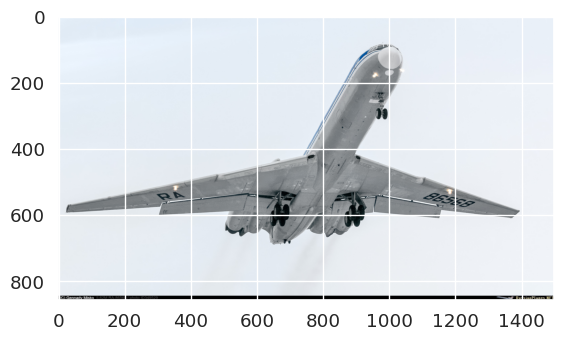

In [57]:
import cv2
from google.colab import drive
drive.mount('/content/drive')
img = cv2.imread("/content/drive/MyDrive/il-62.jpg")
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img = cv2.resize(img,(32,32))
img = img.astype("float32")/255
y = model.predict(np.expand_dims(img,0))
print(y)

**ВЫВОД**

Полученные результаты являются отличными для моделей без сверточных слоев, также accuracy: 0.46 и val_accuracy: 0.46 говорит о том, что мы избежали переобучения модели. С целью справились, улучшили данную сеть без использования сверточных слоев.